<a href="https://colab.research.google.com/github/calvinpozderac/Slide-tag-reconstruction/blob/main/Reconstuction_Phase_Transition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Imports
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
from scipy.special import erf
from scipy.special import comb
from scipy.stats import binom
from scipy.stats import poisson
binom_dist = binom.pmf
from collections import Counter
import matplotlib.patches as patches

import matplotlib.cm as cm
import matplotlib.colors as colors

import time
import pylab as pl
from IPython import display
from IPython.display import clear_output
from scipy.special import expi as ExpIntegralEi
import math
from mpmath import polylog

#!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro
#import numpyro
#import numpyro.distributions as dist
#from numpyro.infer import MCMC, NUTS
#import jax
#import jax.numpy as jnp
#from jax.experimental import mesh_utils
#from jax.sharding import PositionalSharding

#device = "GPU"
#numpyro.set_platform(device)
#jax.config.update('jax_platform_name', device.lower())

#from google.colab import drive
#drive.mount('/content/drive')

# Problem Set Up

---

Consider a disc of radius, $R$, with concentrations $\rho_b$ of beads and $\rho_c$ of cells. Each bead has $N_{mRNA}$ that will diffuse with with diffusion coefficient $D$ for time $t$ to serve as barcodes for the labelling nearby cells. Consequently, the probability that a given barcodes from bead $i$ ends up in cell $j$ is approximated by:

$$p_{ij} = \frac{A (\Delta x)^2}{2 \pi Dt} e^{-\frac{r_{ij}^2}{2Dt}} \equiv \frac{a}{\xi^2}e^{-\frac{r_{ij}^2}{\xi^2}}$$

where $A$ is the absorption rate of the cell, $(\Delta x)^2$ is the area of the cell, and $r_{ij}$ is the distance $|\vec{b_i}-\vec{c_j}|$ between bead $i$ and cell $j$. $\xi$ and $a$ are defined to simplify notation.

In addition to the diffusion process, we can add in an ambient noise term that assumes each bead gives, on average, $k_0$ barcodes to each cell regardless of relative position.

In general, $A$ and $(\Delta x)^2$ can vary from cell to cell and $Dt$ and $k_0$ can vary across beads but we will limit ourselves to considering the uniform case for now.

Ultimately, we expect the total number of barcodes from bead $i$ in cell $j$, $N_{ij}$ to be a random variable drawn from:

$$N_{ij} \sim Pois(N_{mRNA}p_{ij} + k_0).$$

We will simplify notation further by defining $c\equiv a N_{mRNA}/\xi^2$ (the expected number of barcodes a bead would give to a cell that is directly below it) and setting $\xi=1$. Therefore, we are left with:

$$N_{ij} \sim Pois(ce^{-r_{ij}^2} + k_0).$$

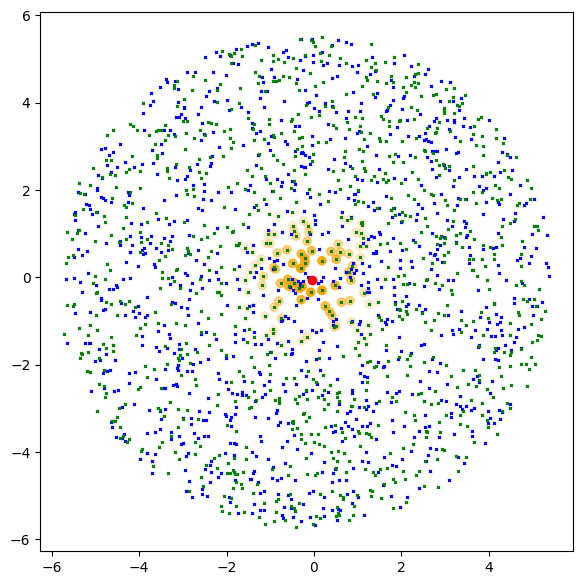

In [ ]:
#@title Simulate data
R = np.sqrt(100/np.pi)
k0 = 0
c = 1000
rhob = 10
rhoc = 10

def create_data(rhob, rhoc, c, k0, R):
    Nb = int(np.round(np.pi*R**2*rhob))
    Nc = int(np.round(np.pi*R**2*rhoc))

    thetas = np.random.rand(Nb)*2*np.pi
    Bs= R*(np.sqrt(np.random.rand(Nb))*np.vstack([np.cos(thetas),np.sin(thetas)])).T

    thetas = np.random.rand(Nc)*2*np.pi
    Cs= R*(np.sqrt(np.random.rand(Nc))*np.vstack([np.cos(thetas),np.sin(thetas)])).T
    mean = c*np.exp(-np.sum((Bs[:,None,:] - Cs[None,:,:])**2, axis = -1))
    Ns = poisson.rvs(mean + k0, size = (Nb, Nc))
    Ns_b = np.sum(Ns,axis = 1)
    Ns_c = np.sum(Ns,axis = 0)
    i = np.where(Ns_b > 0)[0]
    j = np.where(Ns_c > 0)[0]

    center = np.mean(Cs[j], axis = 0)
    return Ns[i][:,j], Bs[i] - center, Cs[j] - center

Ns, Bs, Cs = create_data(rhob, rhoc, c, k0, R)

plt.figure(figsize = (7,7))
ax = plt.axes(aspect = 1)
plt.plot(*Bs.T,'bx', ms = 2)
plt.plot(*Cs.T,'gx', ms = 2)
i = np.argmin(np.linalg.norm(Bs, axis = -1))

plt.plot(*Bs[i],'ro')
plt.scatter(*Cs.T, c='orange', alpha = Ns[i]/np.max(Ns[i]))

# Reconstruction

---

In order to reconstruct the positions of cells and beads from $N_{ij}$ we need to maximize the log-likelihood or equivalently minimize the Hamiltonian, $\mathbb{P} \sim e^{-\beta H}$:

\begin{align}
\beta H = -\text{log}(\mathbb{P}) &= -\sum_{ij}\text{log}\left(\frac{(ce^{-r_{ij}^2} + k_0)^{N_{ij}} e^{-(ce^{-r_{ij}^2} + k_0)}}{N_{ij}!}\right)\\
&= \sum_{ij} -N_{ij}\text{log}(ce^{-r_{ij}^2} + k_0) + ce^{-r_{ij}^2} + const.
\end{align}

Performing gradient descent on the bead and cell positions with this log likelihood is possible with the gradient:

$$\frac{\partial H}{\partial r_{ij}} = 2 c \vec{r_{ij}} e^{-r_{ij}^2} \left(\frac{N_{ij}}{ce^{-r_{ij}^2} + k_0}-1\right)  $$

$$\vec{b_{i}} \rightarrow  \vec{b_{i}} - lr \sum_j \partial_{\vec{r_{ij}}} H$$
$$\vec{c_{j}} \rightarrow  \vec{c_{j}} + lr \sum_i \partial_{\vec{r_{ij}}} H$$

In theory, if we initalize the cell and bead positions randomly, then we can reconstruct the positions through this gradient descent. However, for larger system sizes, local minimum become insurmountable so we need a better initialization.  

# Quadratic approximation
---
For a moment consider $k_0 = 0$ where the Hamiltonian (up to a constant shift) simplifies to:

$$H = \sum_{ij} N_{ij} r_{ij}^2 + ce^{-r_{ij}^2}$$

The first term is a quadratic attraction that is proportional to the number of barcodes from $b_i$ in $c_j$ while the second term is a repulsive term. If we consider the Hamiltonian felt by $c_j$ the repulsive terms roughly average out:
$$H_j = \sum_{i} N_{ij} r_{ij}^2 + ce^{-r_{ij}^2} \approx \sum_{i} N_{ij} r_{ij}^2 = \sum_{i} N_{ij} (\vec{b_i}-\vec{c_j})^2$$  
This allows us to immediately calculate the minimum of the Hamiltonian as:
$$\partial_{c_j}H_j = -2\sum_{i} N_{ij} (\vec{b_i}-\vec{c_j}) = 0 \:\:\: ⇒ \vec{c_j} = \frac{\sum_{i} N_{ij} \vec{b_i}}{\sum_{i} N_{ij}} $$
$$\partial_{b_j}H_i = 2\sum_{j} N_{ij} (\vec{b_i}-\vec{c_j}) = 0 \:\:\: ⇒ \vec{b_i} = \frac{\sum_{j} N_{ij} \vec{c_j}}{\sum_{j} N_{ij}} $$

This approximation grants as an efficient method for approximating the positions. Again begin with a random initialization, then repeatedly apply the above expressions, alternating between the cells and beads. Since we removed the repulsive force, the minimimum is for all of the beads and cells to collapse to a single point. To remedy this effect, we reintroduce repulsion by mandating that the system size remain $R$ after every update.

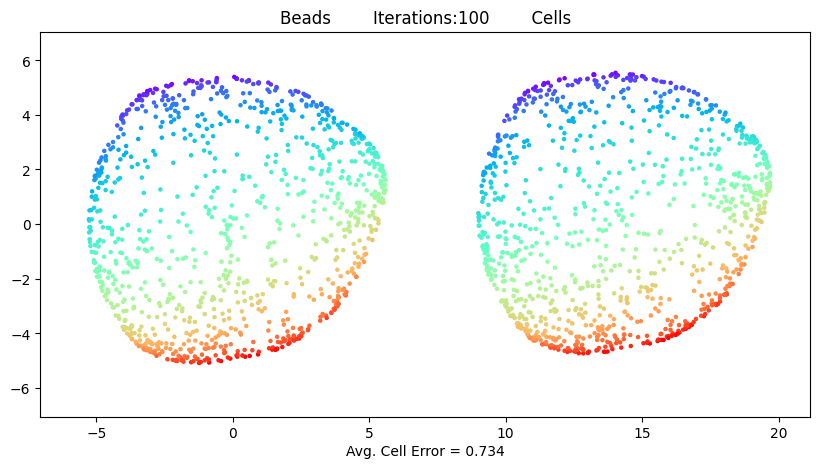

In [ ]:
#@title Quadratic Approximation code
def align(Bs, Cs, bs, cs):

    Cs_center = np.mean(Cs,axis = 0)
    cs_center = np.mean(cs,axis = 0)


    cs_t1 = np.arctan2(*(cs-cs_center)[:,::1].T)
    cs_t2 = np.arctan2(*(cs-cs_center)[:,::-1].T)
    C_t = np.arctan2(*(Cs-Cs_center)[:,::-1].T)

    var1a = np.var((C_t - cs_t1)%(2*np.pi))
    var1b = np.var((C_t - cs_t1+np.pi)%(2*np.pi))
    var2a = np.var((C_t - cs_t2)%(2*np.pi))
    var2b = np.var((C_t - cs_t2+np.pi)%(2*np.pi))
    if True:
        if np.argmin([var1a, var1b, var2a, var2b]) == 0:
            theta = -np.mean((C_t - cs_t1)%(2*np.pi))
            rot = np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
            B = (rot@((bs-cs_center)[:,::-1]).T).T
            C = (rot@((cs-cs_center)[:,::-1]).T).T

        elif np.argmin([var1a, var1b, var2a, var2b]) == 1:
            theta = np.pi-np.mean((C_t - cs_t1+np.pi)%(2*np.pi))
            rot = np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta),np.cos(theta)]])

            B = (rot@((bs-cs_center)[:,::-1]).T).T
            C = (rot@((cs-cs_center)[:,::-1]).T).T

        elif np.argmin([var1a, var1b, var2a, var2b]) == 2:
            theta = -np.mean((C_t - cs_t2)%(2*np.pi))
            rot = np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta),np.cos(theta)]])

            B = (rot@((bs-cs_center)[:,::1]).T).T
            C = (rot@((cs-cs_center)[:,::1]).T).T

        elif np.argmin([var1a, var1b, var2a, var2b]) == 3:
            theta = np.pi-np.mean((C_t - cs_t2+np.pi)%(2*np.pi))
            rot = np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta),np.cos(theta)]])

            B = (rot@((bs-cs_center)[:,::1]).T).T
            C = (rot@((cs-cs_center)[:,::1]).T).T

    return B + Cs_center, C + Cs_center

def error(Bs, Cs, bs, cs, mean = True):
    bsa, csa = align(Bs, Cs, bs, cs)
    B_error = np.linalg.norm(Bs-bsa,axis =1)
    C_error = np.linalg.norm(Cs-csa,axis =1)
    if mean:
        return np.mean(B_error), np.mean(C_error)
    else:
        return B_error, C_error

num = 101
Nb,Nc = Ns.shape
thetas = np.random.rand(Nb)*2*np.pi
bs= R*(np.sqrt(np.random.rand(Nb))*np.vstack([np.cos(thetas),np.sin(thetas)])).T

thetas = np.random.rand(Nc)*2*np.pi
cs= R*(np.sqrt(np.random.rand(Nc))*np.vstack([np.cos(thetas),np.sin(thetas)])).T

Ns_b = np.sum(Ns,axis = 1)
Ns_c = np.sum(Ns,axis = 0)


fig = pl.figure(figsize = (10,5))
ax = plt.axes()
ax.set_aspect(1)
pl.scatter(*bs.T, s = 5, color = cm.rainbow((Bs[:,0]-min(Bs[:,0]))/(max(Bs[:,0])-min(Bs[:,0]))))
pl.scatter(*cs.T+ np.array([2.5*R, 0])[:,None], s = 5, color = cm.rainbow((Cs[:,0]-min(Cs[:,0]))/(max(Cs[:,0])-min(Cs[:,0]))))
pl.title("Beads        Iterations:" + str(0) + "        Cells")
pl.xlim(-R*1.25, R*3.75)
pl.ylim(-R*1.25, R*1.25)
pl.text(R*1.25,-1.5*R, "Avg. Cell Error = " + str(np.round(np.mean(error(Bs, Cs, bs, cs)[1]), 3)), horizontalalignment='center')
display.clear_output(wait=True)
display.display(pl.gcf())
time.sleep(1.0)

for i in range(num):

    bs = np.einsum("ij,jk->ik",Ns,cs)/Ns_b[:,np.newaxis]

    center = np.mean(bs, axis = 0)

    theta = np.random.rand()*2*np.pi
    w1 = 1/np.max(np.abs(np.dot(bs-center, np.array([np.cos(theta),np.sin(theta)]))))
    w2 = 1/np.max(np.abs(np.dot(bs-center, np.array([np.cos(theta+np.pi/2),np.sin(theta+np.pi/2)]))))
    mat = R*np.array([[w1*np.cos(theta)**2 + w2*np.sin(theta)**2,(w1-w2)*np.sin(theta)*np.cos(theta)],[(w1-w2)*np.sin(theta)*np.cos(theta),w1*np.sin(theta)**2 + w2*np.cos(theta)**2]])

    bs = (mat@(bs-center).T).T


    cs = np.einsum("ij,ik->jk",Ns,bs)/Ns_c[:,np.newaxis]


    center = np.mean(cs, axis = 0)

    w1 = 1/np.max(np.abs(np.dot(cs-center, np.array([np.cos(theta),np.sin(theta)]))))
    w2 = 1/np.max(np.abs(np.dot(cs-center, np.array([np.cos(theta+np.pi/2),np.sin(theta+np.pi/2)]))))
    mat = R*np.array([[w1*np.cos(theta)**2 + w2*np.sin(theta)**2,(w1-w2)*np.sin(theta)*np.cos(theta)],[(w1-w2)*np.sin(theta)*np.cos(theta),w1*np.sin(theta)**2 + w2*np.cos(theta)**2]])

    cs = (mat@(cs-center).T).T
    if i <10 or i%10 == 0:
        pl.close(fig)
        fig = pl.figure(figsize = (10,5))
        ax = plt.axes()
        ax.set_aspect(1)
        pl.scatter(*bs.T, s = 5, color = cm.rainbow((Bs[:,0]-min(Bs[:,0]))/(max(Bs[:,0])-min(Bs[:,0]))))
        pl.scatter(*cs.T+ np.array([2.5*R, 0])[:,None], s = 5, color = cm.rainbow((Cs[:,0]-min(Cs[:,0]))/(max(Cs[:,0])-min(Cs[:,0]))))
        pl.title("Beads        Iterations:" + str(i) + "        Cells")
        pl.xlim(-R*1.25, R*3.75)
        pl.ylim(-R*1.25, R*1.25)
        pl.text(R*1.25,-1.5*R, "Avg. Cell Error = " + str(np.round(np.mean(error(Bs, Cs, bs, cs)[1]), 3)), horizontalalignment='center')
        display.clear_output(wait=True)
        display.display(pl.gcf())
        time.sleep(1.0)

    #errors.append(np.mean(error(Bs,Cs,bs,cs)))
    #if i>10:
    #    errors = errors[1:]
    #    if errors[-1] > errors[0]:
    #        break

for i in range(20):
    center = np.mean(bs, axis = 0)
    theta = np.random.rand()*2*np.pi
    w1 = 1/np.max(np.abs(np.dot(bs-center, np.array([np.cos(theta),np.sin(theta)]))))
    w2 = 1/np.max(np.abs(np.dot(bs-center, np.array([np.cos(theta+np.pi/2),np.sin(theta+np.pi/2)]))))
    mat = R*np.array([[w1*np.cos(theta)**2 + w2*np.sin(theta)**2,(w1-w2)*np.sin(theta)*np.cos(theta)],[(w1-w2)*np.sin(theta)*np.cos(theta),w1*np.sin(theta)**2 + w2*np.cos(theta)**2]])

    bs = (mat@(bs-center).T).T

    center = np.mean(cs, axis = 0)

    w1 = 1/np.max(np.abs(np.dot(cs-center, np.array([np.cos(theta),np.sin(theta)]))))
    w2 = 1/np.max(np.abs(np.dot(cs-center, np.array([np.cos(theta+np.pi/2),np.sin(theta+np.pi/2)]))))
    mat = R*np.array([[w1*np.cos(theta)**2 + w2*np.sin(theta)**2,(w1-w2)*np.sin(theta)*np.cos(theta)],[(w1-w2)*np.sin(theta)*np.cos(theta),w1*np.sin(theta)**2 + w2*np.cos(theta)**2]])

    cs = (mat@(cs-center).T).T

pl.close(fig)

bs0 = bs*1
cs0 = cs*1

With a suitably good initialization, we can now simply perform gradient descent to fine tune the positions.

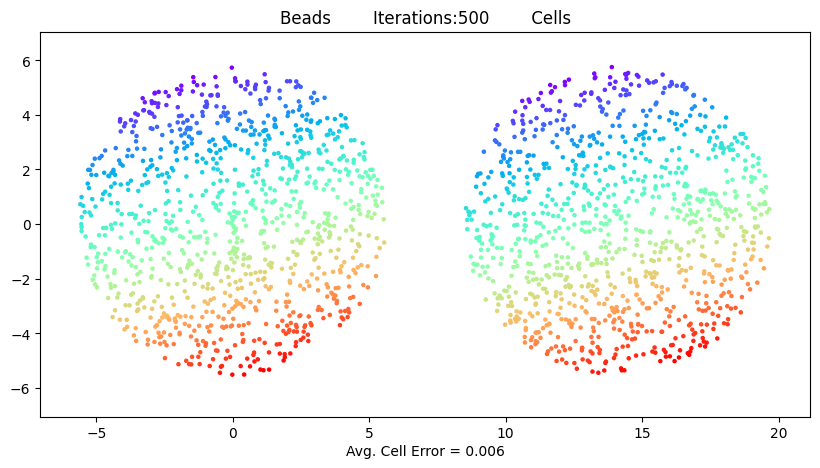

In [ ]:
#@title Gradient Descent
bs = bs0*1
cs = cs0*1
keep = 20
cutoff = 10**-6
mean = c*np.exp(-np.sum((bs[:,None,:]- cs[None,:,:])**2, axis = -1))
delta = (mean*(Ns/(mean+k0)-1))[:,:,None]*(bs[:,None,:]- cs[None,:,:])

diffs = np.vstack([np.mean(delta, axis = 0), np.mean(delta, axis = 1)])
shift0 = np.max(np.linalg.norm(diffs, axis = -1))

lr = R/20/shift0

shifts = []
for k in range(501):
    #Stochastic gradient descent
    #ind_c = np.random.choice(Nc, 100, replace = False)
    #ind_b = np.random.choice(Nb, 100, replace = False)
    #mean = c*np.exp(-np.sum((bs[ind_b,None,:]- cs[None,ind_c,:])**2, axis = -1))
    #delta = (mean*(Ns[ind_b][:,ind_c]/(mean+k0)-1))[:,:,None]*(bs[ind_b,None,:]- cs[None,ind_c,:])

    #db = -np.mean(delta, axis = 1)
    #dc = np.mean(delta, axis = 0)
    #bs[ind_b] += lr*db
    #cs[ind_c] += lr*dc

    mean = c*np.exp(-np.sum((bs[:,None]- cs[None,:])**2, axis = -1))
    delta = (mean*(Ns/(mean+k0)-1))[:,:,None]*(bs[:,None]- cs[None,:])

    db = -np.mean(delta, axis = 1)
    dc = np.mean(delta, axis = 0)
    bs += lr*db
    cs += lr*dc

    diffs = np.vstack([db,dc])

    shifts.append(lr*np.mean(np.linalg.norm(diffs, axis = -1)))

    #if k>keep:
    #    shifts = shifts[1:]
    #    if (np.mean(shifts[:keep//2])*0.9 <= np.mean(shifts[keep//2:])) or np.mean(shifts[keep//2:])<cutoff:
    #        break
    if k%50 == 0:
        pl.close(fig)
        fig = pl.figure(figsize = (10,5))
        ax = plt.axes()
        ax.set_aspect(1)
        pl.scatter(*bs.T, s = 5, color = cm.rainbow((Bs[:,0]-min(Bs[:,0]))/(max(Bs[:,0])-min(Bs[:,0]))))
        pl.scatter(*cs.T+ np.array([2.5*R, 0])[:,None], s = 5, color = cm.rainbow((Cs[:,0]-min(Cs[:,0]))/(max(Cs[:,0])-min(Cs[:,0]))))
        pl.title("Beads        Iterations:" + str(k) + "        Cells")
        pl.xlim(-R*1.25, R*3.75)
        pl.ylim(-R*1.25, R*1.25)
        pl.text(R*1.25,-1.5*R, "Avg. Cell Error = " + str(np.round(np.mean(error(Bs, Cs, bs, cs)[1]), 3)), horizontalalignment='center')

        display.clear_output(wait=True)
        display.display(pl.gcf())
        time.sleep(1.0)
pl.close(fig)

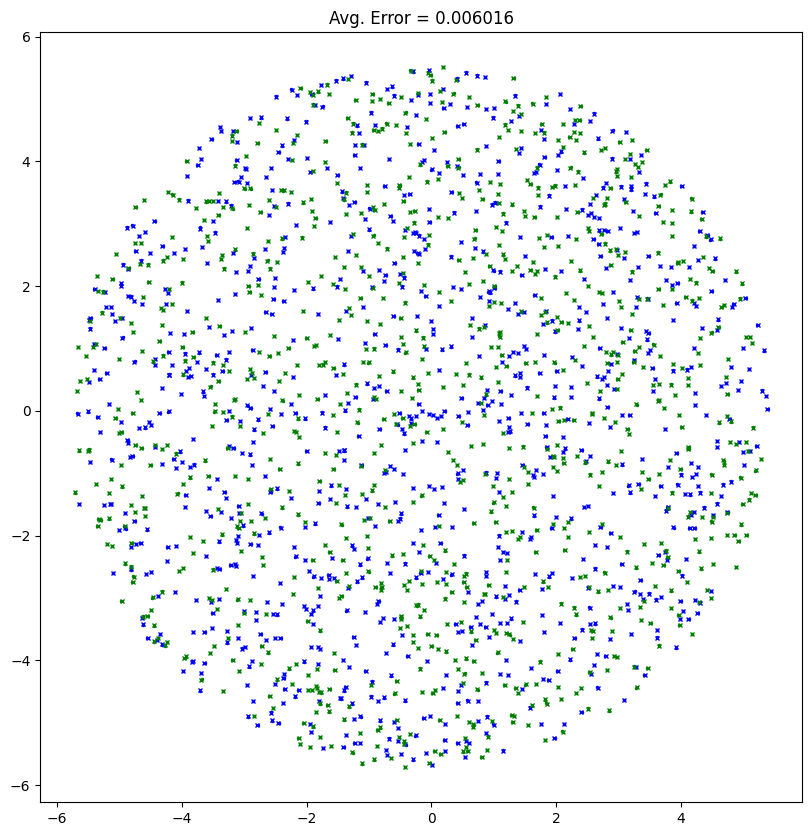

In [ ]:
#@title Results
plt.figure(figsize = (10,10))
ax = plt.axes(aspect = 1)
bs,cs = align(Bs, Cs, bs, cs)
plt.plot(*bs.T,'b.', ms = 3)
plt.plot(*cs.T,'g.', ms = 3)
plt.plot(*Bs.T,'bx', ms = 3)
plt.plot(*Cs.T,'gx', ms = 3)
dB = Bs - bs
dC = Cs - cs
plt.quiver(*bs.T, *dB.T, scale = 1, headwidth = 1.2, angles='xy', scale_units='xy',label = 'Arrows', color = 'b', minlength = 0)
plt.quiver(*cs.T, *dC.T, scale = 1, headwidth = 1.2, angles='xy', scale_units='xy',label = 'Arrows', color = 'g', minlength = 0)
t = plt.title("Avg. Error = " + str(np.round(np.mean(error(Bs, Cs, bs, cs)),6)))

# Reconstruction error
---
We now turn to estimating how well we expect this procedure to do by assuming we are in a reconstructing phase (large $c$, large $\rho_b$, small $k_0$). To estimate the error in a single cells position, we will assume that we know the position of the beads exactly (in reality, there is also some uncertainty in those but accounting for their error is a second order correction). Conisdering a cell at the origin, the reconstruction error is given by the deviations in the minimum of $H_j$ (which is the best we can do in reconstruction).

If we are soundly in the reconstructing phase, then the Hamiltonian from a single bead a distance $r_{ij}$ from the cell is roughly quadratic in the vacinity of the cell:

$$H_{ij}(r) \approx \frac{2(N_{ij}-k_0)^2 r^2}{N_{ij}} (r-\Delta r_{ij})^2 \equiv \alpha_{ij}(r-\Delta r_{ij})^2$$

Here, both $\alpha_{ij}$ and $\Delta r_{ij}$ are random variables that depend on the random variable $N_{ij}$. Using the Poisson definition of $N_{ij}$, we calculate:

$$E[\alpha_{ij}] = \frac{1}{\pi R^2}\int_{0}^{R}2\pi r_{ij} \frac{2 (c e^{-r_{ij}^2})^2 r_{ij}^2}{c e^{-r_{ij}^2} + k_0} dr_{ij}$$
$$E[\alpha_{ij}\Delta r_{ij}] = 0 $$
$$\text{Var}[\alpha_{ij}\Delta r_{ij}] = \frac{1}{2}E[\alpha_{ij}] $$

In 1-D if we sum all of these quadratics the minimum is given by:

$$r_{\text{min}, j} = \frac{\sum_i \alpha_{ij}\Delta r_{ij}}{\sum_i \alpha_{ij}}$$

which has:

$$E[r_{\text{min}, j}] = 0$$
$$\text{Var}[r_{\text{min}, j}] \approx \frac{\text{Var}[\alpha_{ij}\Delta r_{ij}]}{\rho_b \pi R^2 E[\alpha_{ij}]^2} = \frac{1}{2\rho_b \pi R^2 E[\alpha_{ij}]}$$


Evaluating the integral in $E[\alpha_{ij}]$ and taking the $R→\infty$ limit (and properly accounting for the 2D nature) yields:

$$\text{Error} = \frac{1}{\sqrt{4\rho_b \left(c + k_0 \text{Polylog}_2 \left[-\frac{c}{k_0} \right] \right)}}$$

$$\text{Error} \approx  \begin{cases}
      \sqrt{\frac{k_0}{\rho_b}} \frac{1}{c} & c \ll 4k_0 \\
      \frac{1}{\sqrt{4\rho_b c}}            & c \gg 4k_0
   \end{cases}
$$



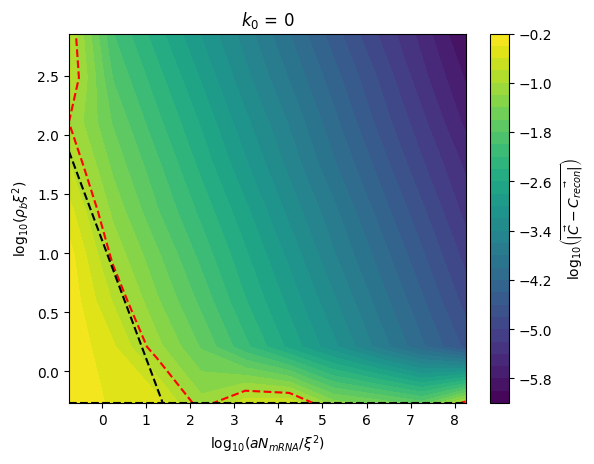

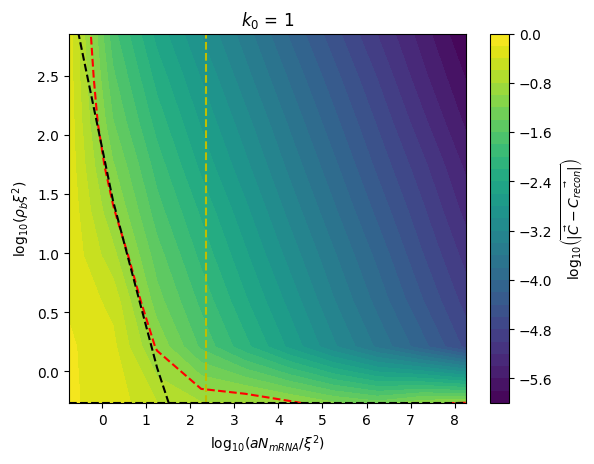

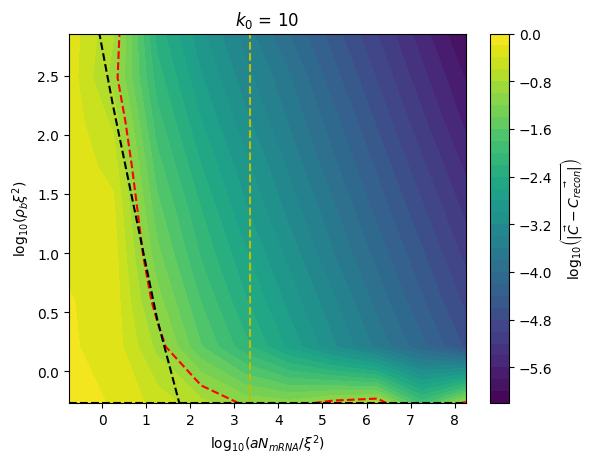

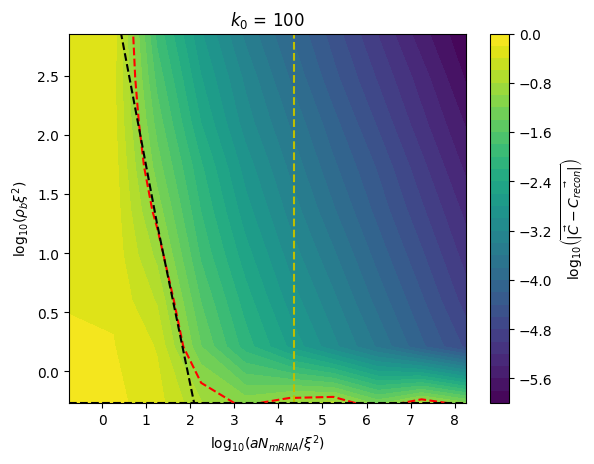

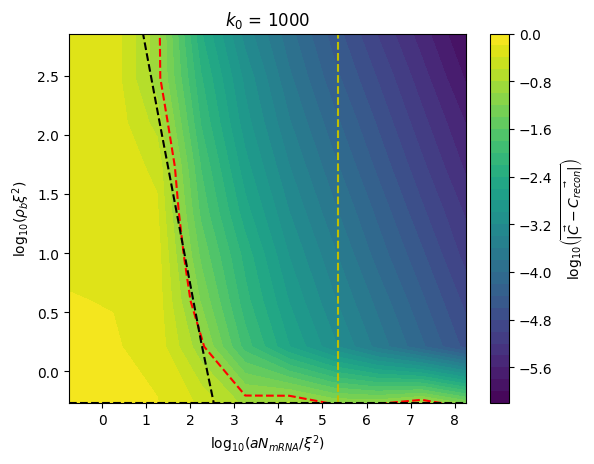

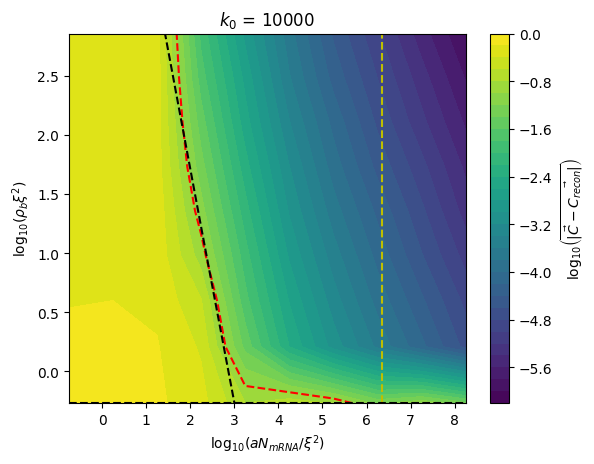

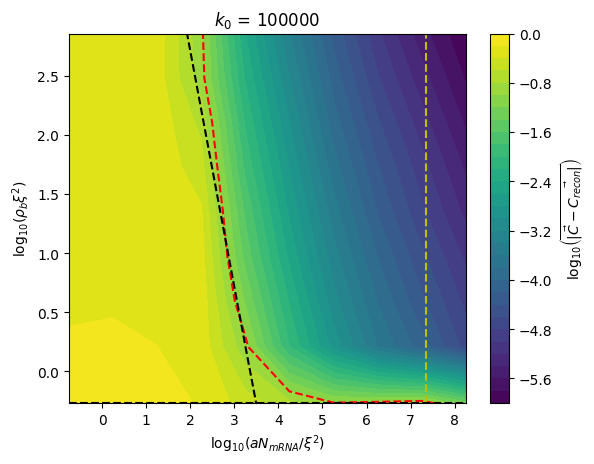

In [ ]:
#@title Simulation results
Nc = 100
xi = 0.3*np.sqrt(2)
Dt = xi**2/2
A = 1
dx = 0.1
a = A*dx**2/np.pi
r = dx*np.sqrt(Nc)/np.sqrt(np.pi)
k0s = np.hstack([np.zeros(1), np.logspace(0,5,6)])
Nbs = np.logspace(np.log10(3.9999),np.log10(4000),9, dtype = int)
NmRNAs = np.logspace(1,10,10, dtype = int)
k0s = np.hstack([np.zeros(1), np.logspace(0,5,6)])
rhob = np.load("/content/drive/MyDrive/Recon_data/rhobs6.npy")
NmRNAs = np.load("/content/drive/MyDrive/Recon_data/NmRNAs6.npy")
errors = np.load("/content/drive/MyDrive/Recon_data/errors6.npy")

for i in range(len(k0s)):
    plt.figure()
    rhob = Nbs/(np.pi*r**2)
    im = plt.contourf(np.log10(a*NmRNAs/xi**2), np.log10(rhob*xi**2), np.log10(np.median(errors,axis = -1))[:,:,i], 30)
    plt.contour(np.log10(a*NmRNAs/xi**2), np.log10(rhob*xi**2), np.log10(np.median(errors,axis = -1))[:,:,i], levels = [np.log10(0.1)], colors = ['r'])
    plt.colorbar(im, label = r"log$_{10}\left(\overline{|\vec{C}-\vec{C_{recon}}|}\right)$")
    plt.ylabel(r"log$_{10}(\rho_b \xi^2)$")
    plt.xlabel(r"log$_{10}(a N_{mRNA}/\xi^2)$")
    if i>0:
        plt.plot(np.log10(a*NmRNAs/xi**2),np.log10(np.array(1/(0.1)**2*9*xi**4/(4*np.pi*a*NmRNAs*(1+k0s[i]*xi**2/a/NmRNAs*[polylog(2, - a*N/xi**2/k0s[i]) for N in NmRNAs])), dtype = float)),'k--')
    else:
        plt.plot(np.log10(a*NmRNAs/xi**2),np.log10(np.array(1/(0.1)**2*9*xi**4/(4*np.pi*a*NmRNAs), dtype = float)),'k--')

    c = a*NmRNAs/xi**2
    R = r/xi
    if i>0:
        plt.axvline(np.log10(4*k0s[i]*xi**2/a),color = 'y', ls = '--')
    plt.plot(np.log10(a*NmRNAs/xi**2),np.log10(np.ones(len(NmRNAs))*3*xi**2/np.pi/r**2),'k--')
    plt.xlim(np.log10(a*NmRNAs[0]/xi**2),np.log10(a*NmRNAs[-1]/xi**2))
    plt.ylim(np.log10(rhob[0]*xi**2),np.log10(rhob[-1]*xi**2))
    from scipy.special import lambertw
    plt.title(r"$k_0$ = "+str(int(k0s[i])))